Download spacy library and polish language model

In [ ]:
!pip install --upgrade spacy
!python -m spacy download pl_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2022-09-15 11:16:44.366791: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.1 MB 2.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import spacy
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection, naive_bayes, svm
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

Load polish language model

In [ ]:

nlp = spacy.load("pl_core_news_sm")
STOP_WORDS = spacy.lang.pl.STOP_WORDS

Load dataset and make basic checks on counts

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Licencjat/DF_rich.xlsx")

In [ ]:
df = df.sort_values("ESE", ascending= False)

In [ ]:
df["ESE"].value_counts()

0.0    1114
1.0     504
Name: ESE, dtype: int64

In [ ]:
#I specifically choose data to make 50/50 ESE+/ESE- to balance the dataset
X = df[:1008]['NO-person'].copy().reset_index(drop=True)
Z = df[:1008]['raw'].copy().reset_index(drop=True)
y = df[:1008]['ESE'].copy().reset_index(drop=True)


In [ ]:
print(y.shape, X.shape)

(1008,) (1008,)


In [ ]:
X.describe()



count                                                  1008
unique                                                  974
top         był w obozie tych, którzy przesuwali kompete...
freq                                                      7
Name: NO-person, dtype: object

Create lemmatization and part of speech functions

In [ ]:
def spacy_lemmatizer(X):
  X = X.apply(lambda row: " ".join([w.lemma_ for w in nlp(row) if not w.is_punct]))
  return X


def spacy_pos(X):
  X = X.apply(lambda row: " ".join([w.pos_ for w in nlp(row)]))
  return X



In [ ]:
X

0        PiS i PO nie zajmują się zdobywaniem funduszy...
1       panie prezydencie, pan przez 5 lat nie przyjec...
2        jako  będzie intensywnie pracował nad tym, że...
3       polscy przedsiębiorcy teraz są poddani eksterm...
4        zapowiedział wczoraj, że w ramach rozdziału K...
                              ...                        
1003    mamy prawo wiedzieć, czy dzieci wrócą do szkół...
1004      dzisiaj trzeba zadawać trudne pytania rządzącym
1005                                     I tańsze państwo
1006             dla Polek i Polaków niewiele się zmienia
1007          w Polsce szybciej przyjmiemy ruble niż euro
Name: NO-person, Length: 1008, dtype: object

Create train and test datasets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state = 42)
Z_train, Z_test, a_train, a_test = train_test_split(Z,y,test_size = 0.33, random_state = 42)

In [ ]:
X_train.describe()

count                                                   675
unique                                                  656
top         był w obozie tych, którzy przesuwali kompete...
freq                                                      5
Name: NO-person, dtype: object


# Lemma analysis and machine learning classification

Create dummy classifier for baseline

In [ ]:
dummy_clf = DummyClassifier(strategy="uniform")

In [ ]:
dummy_clf.fit(X_train,y_train)
pred=dummy_clf.predict(X_test)
print("Accuracy = "+str(metrics.accuracy_score(y_test, pred)))
print("Precision = "+str(metrics.precision_score(y_test, pred)))
print("Recall = "+str(metrics.recall_score(y_test, pred)))
# f1 score
print("F1 score = "+ str(f1_score(y_test, pred)))

Accuracy = 0.46546546546546547
Precision = 0.4819277108433735
Recall = 0.46511627906976744
F1 score = 0.4733727810650888


Create SVC model. Train it on lemmatized data and test the score.

In [ ]:
#pierwszy algorytm SVC; liczba komponentów 500?
text_clf_svc = Pipeline([("custom_function spacy", FunctionTransformer(spacy_lemmatizer)), ('tfidf', TfidfVectorizer()),('PCA-TruncatedSVD', TruncatedSVD(n_components=500)), ('clf', svm.SVC(probability=True))])
text_clf_svc.fit(X_train,y_train)
predictions = text_clf_svc.predict(X_test)
predictions_train_LEM_SVC = text_clf_svc.predict_proba(X_train)
predictions_test_LEM_SVC = text_clf_svc.predict_proba(X_test)
print(metrics.confusion_matrix(y_test, predictions))
# Print the overall accuracy
print("Accuracy = "+str(metrics.accuracy_score(y_test, predictions)))
print("Precision = "+str(metrics.precision_score(y_test, predictions)))
print("Recall = "+str(metrics.recall_score(y_test, predictions)))
# f1 score
print("F1 score = "+ str(f1_score(y_test, predictions)))

[[118  43]
 [ 61 111]]
Accuracy = 0.6876876876876877
Precision = 0.7207792207792207
Recall = 0.6453488372093024
F1 score = 0.6809815950920245


Create variables to plot ROC curve to visualize data

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,predictions)
roc_auc = metrics.auc(fpr, tpr)

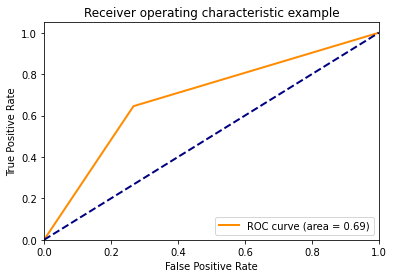

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" %roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

Create Multinomial Naive Bayes model. Train it on lemmatized data and test the score.

In [ ]:
#Multinomial NaiveBayes
text_clf_nb = Pipeline([("custom_function spacy", FunctionTransformer(spacy_lemmatizer)),('tfidf', TfidfVectorizer()), ('clf', MultinomialNB(alpha=0.01))])
text_clf_nb.fit(X_train,y_train)
predictions = text_clf_nb.predict(X_test)
predictions_train_LEM_NB = text_clf_svc.predict_proba(Z_train)
predictions_test_LEM_NB = text_clf_svc.predict_proba(Z_test)
print(metrics.confusion_matrix(y_test, predictions))
# Print the overall accuracy
print("Accuracy = "+str(metrics.accuracy_score(y_test, predictions)))
print("Precision = "+str(metrics.precision_score(y_test, predictions)))
print("Recall = "+str(metrics.recall_score(y_test, predictions)))
# f1 score
print("F1 score = "+ str(f1_score(y_test, predictions)))

[[118  43]
 [ 63 109]]
Accuracy = 0.6816816816816816
Precision = 0.7171052631578947
Recall = 0.6337209302325582
F1 score = 0.6728395061728395


Create Maximum Entrophy model. Train it on lemmatized data and test the score.

In [ ]:
#Maximum Entrophy
text_clf_RF = Pipeline([('tfidf', TfidfVectorizer()),('PCA-TruncatedSVD', TruncatedSVD(n_components=500)),('clf', LogisticRegression(penalty = 'none'))])
text_clf_RF.fit(X_train,y_train)
predictions = text_clf_RF.predict(X_test)
predictions_train_LEM_LR = text_clf_RF.predict_proba(X_train)
predictions_test_LEM_LR = text_clf_RF.predict_proba(X_test)
print(metrics.confusion_matrix(a_test, predictions))
# Print the overall accuracy
print("Accuracy = "+str(metrics.accuracy_score(y_test, predictions)))
print("Precision = "+str(metrics.precision_score(y_test, predictions)))
print("Recall = "+str(metrics.recall_score(y_test, predictions)))
# f1 score
print("F1 score = "+ str(f1_score(y_test, predictions)))

[[103  58]
 [ 56 116]]
Accuracy = 0.6576576576576577
Precision = 0.6666666666666666
Recall = 0.6744186046511628
F1 score = 0.6705202312138728



# POS analysis and machine learning classification

Create SVC model. Train it on POS data and test the score.

In [ ]:
#SVC
text_clf_svc = Pipeline([("custom_function spacy", FunctionTransformer(spacy_pos)),('tfidf', TfidfVectorizer()), ('clf', svm.SVC(probability=True))])
text_clf_svc.fit(Z_train,a_train)
predictions = text_clf_svc.predict(Z_test)
predictions_train_POS_SVC = text_clf_svc.predict_proba(Z_train)
predictions_test_POS_SVC = text_clf_svc.predict_proba(Z_test)
print(metrics.confusion_matrix(a_test, predictions))
# Print the overall accuracy
print("Accuracy = "+str(metrics.accuracy_score(y_test, predictions)))
print("Precision = "+str(metrics.precision_score(y_test, predictions)))
print("Recall = "+str(metrics.recall_score(y_test, predictions)))
# f1 score
print("F1 score = "+ str(f1_score(y_test, predictions)))

[[95 66]
 [74 98]]
Accuracy = 0.5795795795795796
Precision = 0.5975609756097561
Recall = 0.5697674418604651
F1 score = 0.5833333333333334


Create Multinomial Naive Bayes model. Train it on POS data and test the score.

In [ ]:
#MultinomialNB
text_clf_svc = Pipeline([("custom_function spacy", FunctionTransformer(spacy_pos)),('tfidf', TfidfVectorizer()), ('clf', MultinomialNB(alpha=0.01))])
text_clf_svc.fit(Z_train,a_train)
predictions = text_clf_svc.predict(Z_test)
predictions_train_POS_NB = text_clf_svc.predict_proba(Z_train)
predictions_test_POS_NB = text_clf_svc.predict_proba(Z_test)
print(metrics.confusion_matrix(a_test, predictions))
# Print the overall accuracy
print("Accuracy = "+str(metrics.accuracy_score(y_test, predictions)))
print("Precision = "+str(metrics.precision_score(y_test, predictions)))
print("Recall = "+str(metrics.recall_score(y_test, predictions)))
# f1 score
print("F1 score = "+ str(f1_score(y_test, predictions)))

[[98 63]
 [79 93]]
Accuracy = 0.5735735735735735
Precision = 0.5961538461538461
Recall = 0.5406976744186046
F1 score = 0.5670731707317073


Create Maximum Entrophy model. Train it on POS data and test the score.

In [ ]:
#Maximum Entrophy
text_clf_svc = Pipeline([("custom_function spacy", FunctionTransformer(spacy_pos)),('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])
text_clf_svc.fit(Z_train,a_train)
predictions = text_clf_svc.predict(Z_test)
predictions_train_POS_LR = text_clf_svc.predict_proba(Z_train)
predictions_test_POS_LR = text_clf_svc.predict_proba(Z_test)
print(metrics.confusion_matrix(a_test, predictions))
# Print the overall accuracy
print("Accuracy = "+str(metrics.accuracy_score(y_test, predictions)))
print("Precision = "+str(metrics.precision_score(y_test, predictions)))
print("Recall = "+str(metrics.recall_score(y_test, predictions)))
# f1 score
print("F1 score = "+ str(f1_score(y_test, predictions)))

[[ 94  67]
 [ 71 101]]
Accuracy = 0.5855855855855856
Precision = 0.6011904761904762
Recall = 0.5872093023255814
F1 score = 0.5941176470588235


#Meta models using "stacking" - that means joining results from previous lemma and POS classification and using another model to predict class based on the results of previous models.

In [ ]:
new_train=pd.merge(pd.DataFrame(predictions_train_POS_SVC[:,0],columns=['POS']),pd.DataFrame(predictions_train_LEM_SVC[:,0],columns=['LEM']),left_index=True, right_index=True)
new_test = pd.merge(pd.DataFrame(predictions_test_POS_SVC[:,0],columns=['POS']),pd.DataFrame(predictions_test_LEM_SVC[:,0],columns=['LEM']),left_index=True, right_index=True)

Create meta model train and test set

In [ ]:
def ensemble_set(A_POS,B_LEM):
  return pd.merge(pd.DataFrame(A_POS[:,0],columns=['POS']),pd.DataFrame(B_LEM[:,0],columns=['LEM']),left_index=True, right_index=True)

In [ ]:
new_train = ensemble_set(predictions_train_POS_LR,predictions_train_LEM_SVC)
new_test = ensemble_set(predictions_test_POS_LR,predictions_test_LEM_SVC)

Create SVC model. Train it on meta data and test the score.

In [ ]:
#SVC
text_clf_svc_new = svm.SVC()
text_clf_svc_new.fit(new_train,y_train)
predictions = text_clf_svc_new.predict(new_test)
print(metrics.confusion_matrix(y_test, predictions))
# Print the overall accuracy
print("Accuracy = "+str(metrics.accuracy_score(y_test, predictions)))
print("Precision = "+str(metrics.precision_score(y_test, predictions)))
print("Recall = "+str(metrics.recall_score(y_test, predictions)))
# f1 score
print("F1 score = "+ str(f1_score(y_test, predictions)))

[[112  49]
 [ 50 122]]
Accuracy = 0.7027027027027027
Precision = 0.7134502923976608
Recall = 0.7093023255813954
F1 score = 0.7113702623906706


Create Multinomial Naive Bayes model. Train it on POS data and test the score.

In [ ]:
#NB
text_clf_NB_new =  MultinomialNB()
text_clf_NB_new.fit(new_train,y_train)
predictions = text_clf_NB_new.predict(new_test)
print(metrics.confusion_matrix(y_test, predictions))
# Print the overall accuracy
print("Accuracy = "+str(metrics.accuracy_score(y_test, predictions)))
print("Precision = "+str(metrics.precision_score(y_test, predictions)))
print("Recall = "+str(metrics.recall_score(y_test, predictions)))
# f1 score
print("F1 score = "+ str(f1_score(y_test, predictions)))

[[141  20]
 [ 99  73]]
Accuracy = 0.6426426426426426
Precision = 0.7849462365591398
Recall = 0.42441860465116277
F1 score = 0.5509433962264151


Create Maximum Entrophy model. Train it on meta data and test the score.

In [ ]:
#Maximum Entrophy
text_clf_LR_new =  LogisticRegression()
text_clf_LR_new.fit(new_train,y_train)
predictions = text_clf_LR_new.predict(new_test)
print(metrics.confusion_matrix(y_test, predictions))
# Print the overall accuracy
print("Accuracy = "+str(metrics.accuracy_score(y_test, predictions)))
print("Precision = "+str(metrics.precision_score(y_test, predictions)))
print("Recall = "+str(metrics.recall_score(y_test, predictions)))
# f1 score
print("F1 score = "+ str(f1_score(y_test, predictions)))

[[118  43]
 [ 61 111]]
Accuracy = 0.6876876876876877
Precision = 0.7207792207792207
Recall = 0.6453488372093024
F1 score = 0.6809815950920245
